Audio Neural Style Transfer with Pytorch
============================
This is an implementation of neural style transfer using the alogrithm developed in
[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.

However instead of learning style from images we use the spectrogram in place to carry out the procedure on audio.

General implementation is based off the [Pytorch tutorial on Neural Transfer](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html) by Alexis Jacq. Also inspired by [Audio texture synthesis](https://github.com/DmitryUlyanov/neural-style-audio-torch) by Dmitry Ulyanov.

In [35]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

import copy
import os
import math

#for random feature projection
from scipy.stats import ortho_group


import soundfile as sf
from matplotlib.pyplot import figure

In [36]:
def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img

<div style="background-color: honeydew">
<h2> Session Parameters </h2>
</div>

In [37]:
# True uses PGHI (Truncated Gaussian window, log mag, PGHI reconstruction)
# False uses Log Mag spectrum and Griffin Lim reconstruction
tifresi=True

#STYLE_FILENAME = "inputs/lemons.wav" #input filename
STYLE_FILENAME = "inputs/gansounds/pops4secs.wav" #input filename
#STYLE_FILENAME = "inputs/gansounds/hubub.10secs.wav" #input filename


#Go up to 20000 for high quality if you are on a GPU
num_steps=2000

RANDOM_PROJECTION="None"
SYNTHETIC_LENGTH_FACTOR = 1 # duration of generated relative to target texture

#MS Number of separate CNNs operating on input
numStreams=2
learning_Rate=.001  # must be smaller for more streams (if numStream=1, then learning_Rate can be 1)

In [38]:
display(Audio(STYLE_FILENAME))

<div style="background-color: honeydew">
<h2> FFT and CNN parameters  </h2>
(probably don't need to change)
</div>

In [39]:
# set filenames
outname = 'rftests' #output dir
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

#librosa audio params
N_FFT = 512 
K_HOP = 128 

# architecture
"""use a custom convolutional network randomly initialized""" 
use01scale = False #set to true if want to scale img to [0,1] prior to training. Recommended if using VGG19
boundopt = False #whether to regularize the input within [lower,upper]. Recommended if using VGG19
whichChannel = "freq" #2d=2d conv, 1d options:freq=freq bins as channels, time= time bins as channels 
N_FILTERS = 256# 4096 #no. of filters in 1st conv layer
hor_filter = 5 #width of conv filter, for 2d also the height of (square) kernel


<div style="background-color: honeydew">
<h4> TFResi params  </h4>
(probably don't need to change)  
</div>  

[Link to tfresi code.](https://github.com/andimarafioti/tifresi)

In [40]:
from tifresi.hparams import HParams
from tifresi.stft import GaussTruncTF

#from tifresi.transforms import log_spectrogram
#from tifresi.transforms import inv_log_spectrogram
#NOTE: Not using Marifioties 10 log_10 transform. Instead use natural log.
# This makes a HUGE difference !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
log_spectrogram=log_scale
inv_log_spectrogram=inv_log

stft_channels = HParams.stft_channels = N_FFT 
hop_size =  HParams.hop_size  = K_HOP
HParams.sr=16000 

# empirically set: - too small, get low-res ringing; too high, get distortion
tfresiMagSpectScale=5 # Takes the [0,1] mag spectrogram and maps it to [0, tfresiMagSpectScale]

# For faster processin, a truncated window can be used instead
stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)


<div style="background-color: honeydew">
<h4> Plumbing  </h4>
</div>  

In [41]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [42]:
def read_audio_spectum(filename, tifresi=True):
    #x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    x, fs  = sf.read(filename)
    print(f'input file sample rate = {fs}')
    x=np.append(x, np.zeros(stft_channels-np.mod(len(x), stft_channels)))
    N_SAMPLES = len(x)
    x=x+np.random.normal(scale=.0001, size=N_SAMPLES)
    print(f'np.mod(len(x), stft_channels) = {np.mod(len(x), stft_channels)}')
    print(f' number of hops is {len(x)//hop_size}')
    
    if tifresi :
        print(f'In read audio, doing tifresi spectrogram')
        R=tfresiMagSpectScale*stft_system.spectrogram(x)
    else :
        print(f'In read audio, doing librosa spectrogram')
        R = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=False))    
        
    print(f'R range is  [{np.amin(R)}, {np.amax(R)}')
    print(f'K_HOP - {K_HOP} and N_FFT is {N_FFT}')
    print(f'R shape is {R.shape}')
    return R, fs


def findMinMax(img):
    return int(math.floor(np.amin(img))),int(math.ceil(np.amax(img)))

def img_scale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [datasetMin,datasetMax] -> [scaleMin,scaleMax]"""    
    shift = (scaleMax-scaleMin) / (datasetMax-datasetMin)
    scaled_values = shift * (img-datasetMin) + scaleMin
    print("img_scale: Using [{0},{1}] -> [{2},{3}] for scale conversion".format(datasetMin,datasetMax,scaleMin,scaleMax))
    return scaled_values

def img_invscale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [scaleMin,scaleMax] -> [datasetMin,datasetMax]"""
    shift = (datasetMax-datasetMin) / (scaleMax-scaleMin)
    scaled_values = shift * (img-scaleMin) + datasetMin
    print("img_invscale: Using [{0},{1}] -> [{2},{3}] for inverse scale conversion".format(scaleMin,scaleMax,datasetMin,datasetMax))
    return scaled_values
    
#if 0
    # use below functions to use librosa db scale, normalized to [0,1]
    # note that this scaling does not work well for style transfer
    def db_scale(img,scale=80):
        img = librosa.amplitude_to_db(img)
        shift = float(np.amax(img))
        img = img - shift #put max at 0
        img = img/scale #scale from [-80,0] to [-1,0]
        img = img + 1. #shift to [0,1]
        img = np.maximum(img, 0) #clip anything below 0
        return img, shift

    def inv_db(img,shift,scale=80):
        img = img - 1. #shift from [0,1] to [-1,0]
        img = img * scale #[-1,0] -> [-80,0]
        img = img + shift
        img = librosa.db_to_amplitude(img)    
        return img

<div style="background-color: #AAFFAA">
<h4> Prepare input and inspect.  </h4>
</div>  

In [43]:
R, fs = read_audio_spectum(STYLE_FILENAME, tifresi)
print(f"raw spectrogram R range before log and scaling: [{np.amin(R)},{np.amax(R)}] ")


input file sample rate = 16000
np.mod(len(x), stft_channels) = 0
 number of hops is 504
In read audio, doing tifresi spectrogram
R range is  [9.669274233589405e-08, 5.0
K_HOP - 128 and N_FFT is 512
R shape is (257, 504)
raw spectrogram R range before log and scaling: [9.669274233589405e-08,5.0] 


In [44]:
if tifresi :
    print('TIFResi: log_spectrogram')
    a_style = log_spectrogram(R)
else :
    print('HUZ: log_scase')
    a_style = log_scale(R)
    
print(f"    LOG    range before scaling: [{np.amin(a_style)},{np.amax(a_style)}]",)
print(f'shape of a_style is {a_style.shape}')


TIFResi: log_spectrogram
    LOG    range before scaling: [9.669273766115113e-08,1.791759469228055]
shape of a_style is (257, 504)


In [45]:
if use01scale == True:
    a_min,a_max = findMinMax(a_style)
    a_style = img_scale(a_style,a_min,a_max,0,1)

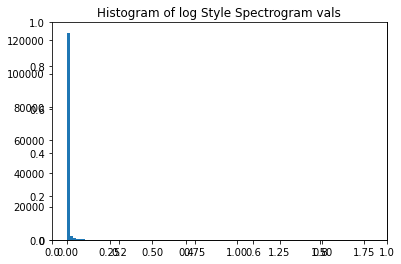

Max bin: 9.669273766115113e-08
Style spectrogram range after scaling: 9.669273766115113e-08 1.791759469228055


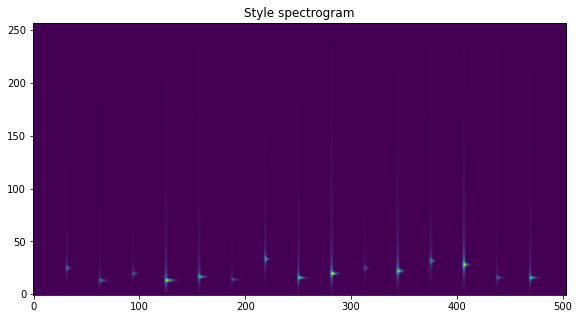

In [46]:
"""we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
#plt.ion()
fig = plt.figure()
plt.title('Histogram of log Style Spectrogram vals')
ax = fig.add_subplot(111)
#n,b,_ = ax.hist(a_style.flatten(),bins='auto')
n,b,_ = ax.hist(a_style.flatten(),bins=100)
#ax.set_yticklabels([])
#ax.set_xticks([])
maxbin = np.argmax(n)
plt.show()
print("Max bin:",b[maxbin])

plt.figure(figsize=(10, 5))
plt.title('Style spectrogram')
plt.imshow(a_style, origin='lower')
print("Style spectrogram range after scaling:",np.amin(a_style),np.amax(a_style))
temp_a_style=a_style # for reality check in next cell

In [47]:

if 0 : #RUN PGHI ON THE ORIGINAL INPUT DATA SPECTROGRAM  - ASSUMING TFRESI for the little experiment in this cell
    # now invert it, just like we will do with the GAN-generated images

    #SPECTOFFSET
    SPECTOFFSET=.25

    lspect=a_style
    print(f' shape of lspect is {bar.shape}')
    #ASSUMING TIFRES
    print('TIFResi: inv_log_spectrogram')
    if use01scale == True:
        foo = img_invscale(lspect,a_min,a_max,0,1)
        out_spec = inv_log_spectrogram(lspect+ SPECTOFFSET) 
        print(f'   RESCALED: Min/Max of outputs:  {np.amin(out_spec)},{np.amax(out_spec)}') # check values make sense

    else:
        out_spec =inv_log_spectrogram(lspect+SPECTOFFSET) 
        print(f'   inv_log_spectrogram: Min/Max of outputs:  {np.amin(out_spec)},{np.amax(out_spec)}') # check values make sense

    print(f' shape of out_spec is {out_spec.shape}')
    bar = np.clip(out_spec, 0,None)
    print(f' shape of bar is {bar.shape}')

    print(f'Min/Max of spectrogram: {np.amin(bar)}, {np.amax(bar)}') # check values make sense
    x = stft_system.invert_spectrogram(bar) 

    display(Audio(x, rate=16000, autoplay=True))


In [48]:
N_SAMPLES = a_style.shape[1] #time bins
N_FREQ = a_style.shape[0] #freq bins

a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
if whichChannel == "2d":
    a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]
elif whichChannel == "freq":
    a_style = torch.from_numpy(a_style).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]
elif whichChannel == "time":
    a_style = torch.from_numpy(a_style).permute(0,3,1,2) #pytorch:[batch,channels(samples),height(1),width(freq)]

style_img = Variable(a_style).type(dtype) #convert to pytorch variable
print("Using whichChannel ==",whichChannel," Input shape:",style_img.data.shape) #check shape is correct

Using whichChannel == freq  Input shape: torch.Size([1, 257, 1, 504])


(257, 504)
Output range: 9.669274e-08 1.7917595


<Figure size 720x360 with 0 Axes>

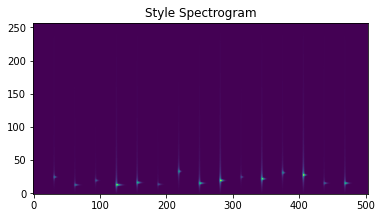

In [49]:
def imshow(tensor, n_freqs, n_samples, channels=1, title=None, origin='lower'):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    if whichChannel == "2d":
        image = image
    if whichChannel == "freq":
        image = image.permute(0,2,1,3).contiguous() # get the dimensions in proper order
    elif whichChannel == "time":
        image = image.permute(0,2,3,1).contiguous() # get the dimensions in proper order
    image = image.view(n_freqs, n_samples)  # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    print("Output range:",np.amin(image),np.amax(image))
    
    
    plt.imshow(image, origin=origin)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image #return numpy array

"Just to check we can get back the numpy array with the correct shape"
plt.figure(figsize=(10, 5))
plt.figure()
_=imshow(style_img.data, N_FREQ, N_SAMPLES, title='Style Spectrogram', origin='lower')

#plt.figure()
#imshow(content_img.data, title='Content Image')

<div style="background-color: #FF4488">
<h4> BeginNetwork   </h4>
</div>

<div style="background-color: #AAFFAA">
<h4> Create network   </h4>
</div>  

In [50]:
"Here we create the custom network"
import collections as c

if whichChannel == "2d":
    IN_CHANNELS = 1
elif whichChannel == "freq":
    IN_CHANNELS = N_FREQ
elif whichChannel == "time":
    IN_CHANNELS = N_SAMPLES
    

# custom weights initialization
def weights_init(m):
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQ + N_FILTERS) * hor_filter))
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, std)

class style_net(nn.Module):
    """Here create the network you want to use by adding/removing layers in nn.Sequential"""
    def __init__(self):
        super(style_net, self).__init__()
        self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(IN_CHANNELS,N_FILTERS,kernel_size=(1,hor_filter),bias=False)),
                            ('relu1',nn.ReLU()),
                            ('max1', nn.MaxPool2d(kernel_size=(1,2))),
            
                            ('conv2',nn.Conv2d(N_FILTERS,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
                            ('relu2',nn.ReLU())]))

                            #('relu2',nn.ReLU()),
                            #('max2', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv3',nn.Conv2d(N_FILTERS//2,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
                            #('relu3',nn.ReLU()),
                            #('max3', nn.MaxPool2d(kernel_size=(1,2))),

                            #('conv4',nn.Conv2d(N_FILTERS//2,N_FILTERS//4,kernel_size=(1,hor_filter),bias=False)),
                            #('relu4',nn.ReLU()),
                            #('max4', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv5',nn.Conv2d(N_FILTERS//4,N_FILTERS//4,kernel_size=(1,hor_filter),bias=False)),
                            #('relu5',nn.ReLU()),
                            #('max5', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv6',nn.Conv2d(N_FILTERS//4,N_FILTERS//8,kernel_size=(1,hor_filter),bias=False)),
                            #('relu6',nn.ReLU())]))

    def forward(self,input):
        out = self.layers(input)
        return out
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
cnnlist=[] 
#MS create a separate CNN for each stream
for j in range(numStreams) :
    cnn = style_net()
    cnn.apply(weights_init)
    for param in cnn.parameters():
        param.requires_grad = False
    print(list(cnn.layers))

    # move it to the GPU if possible:
    if use_cuda:
        cnn = cnn.cuda()
    
    cnnlist.append(cnn)

# Add the style/content loss 'layer' after the specified layer:
content_layers_default = [] #ignore for now
#style_layers_default = ['relu_1']
style_layers_default = ['relu_1', 'relu_2']

[Conv2d(257, 256, kernel_size=(1, 5), stride=(1, 1), bias=False), ReLU(), MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False), Conv2d(256, 128, kernel_size=(1, 5), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 256, kernel_size=(1, 5), stride=(1, 1), bias=False), ReLU(), MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False), Conv2d(256, 128, kernel_size=(1, 5), stride=(1, 1), bias=False), ReLU()]


Content loss
~~~~~~~~~~~~

The content loss is a function that takes as input the feature maps
$F_{XL}$ at a layer $L$ in a network fed by $X$ and
return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between
this image and the content image. Hence, the weight $w_{CL}$ and
the target content $F_{CL}$ are parameters of the function. We
implement this function as a torch module with a constructor that takes
these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is
the Mean Square Error between the two sets of feature maps, that can be
computed using a criterion ``nn.MSELoss`` stated as a third parameter.

We will add our content losses at each desired layer as additive modules
of the neural network. That way, each time we will feed the network with
an input image $X$, all the content losses will be computed at the
desired layers and, thanks to autograd, all the gradients will be
computed. For that, we just need to make the ``forward`` method of our
module returning the input: the module becomes a ''transparent layer''
of the neural network. The computed loss is saved as a parameter of the
module.

Finally, we define a fake ``backward`` method, that just call the
backward method of ``nn.MSELoss`` in order to reconstruct the gradient.
This method returns the computed loss: this will be useful when running
the gradient descent in order to display the evolution of style and
content losses.




In [51]:
class ContentLoss(nn.Module):
    """Since doing texture only we ignore this for now"""

    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

.. Note::
   **Important detail**: this module, although it is named ``ContentLoss``,
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss, you have to create a PyTorch autograd Function
   and to recompute/implement the gradient by the hand in the ``backward``
   method.

Style loss
~~~~~~~~~~

For the style loss, we need first to define a module that compute the
gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$\ x\ $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:




In [52]:
# create random feature projection matrix
RFM={}

# This is the "sparse" Achlioptas matrix
if RANDOM_PROJECTION=="Sparse" : 
    RFM[1024]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (1024,512), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[512]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (512,256), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[256]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (256,128), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[128]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (128,64), p=[1./6.,2./3., 1./6.])).type(dtype)

#Full orthonormal gaussian 
if RANDOM_PROJECTION=="Gaussian" : 
    RFM[1024]=torch.from_numpy(ortho_group.rvs(1024)[:512]).type(dtype)
    RFM[512]=torch.from_numpy(ortho_group.rvs(512)[:256]).type(dtype)
    RFM[256]=torch.from_numpy(ortho_group.rvs(256)[:128]).type(dtype)
    RFM[128]=torch.from_numpy(ortho_group.rvs(128)[:64]).type(dtype)

In [53]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1
        #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL
        
       # features2=torch.matmul(RFM[:b//2,:b], features)
        if RANDOM_PROJECTION=="None":
            features2=features
        else :
            features2=torch.matmul(RFM[b], features)

        G = torch.mm(features2, features2.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d)

The longer is the feature maps dimension $N$, the bigger are the
values of the gram matrix. Therefore, if we don't normalize by $N$,
the loss computed at the first layers (before pooling layers) will have
much more importance during the gradient descent. We dont want that,
since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the
content loss module, but we have to add the ``gramMatrix`` as a
parameter:




In [54]:
#foofoo
class StyleLoss(nn.Module):

    def __init__(self, target, weight, layer): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss(size_average=False)
        #print(f'Creating StyleLoss module - this one for layer {layer} with target shape {target.shape}' )


    def forward(self, input):
        #print(f' StyleLoss.forward with input of shape {input.shape}')
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=True)
        return self.loss

In [55]:
class OptReg(nn.Module):
    """soft bound the optimization between [lower,upper] by regularization"""
    
    def __init__(self, upper, lower, weight=1): #weight here is the alpha tuning (how much content vs style)
        super(OptReg, self).__init__()
        self.upper = Variable(torch.cuda.FloatTensor([upper]))
        self.lower = Variable(torch.cuda.FloatTensor([lower]))
        self.weight = weight

    def forward(self, input):
        #self.output = input.clone()
        self.zeros = Variable(torch.zeros(input.size()).type(dtype))
                              
        self.over = torch.max(input-self.upper,self.zeros)
        self.under = torch.max(self.lower-input,self.zeros)
        self.total= self.over + self.under
        self.l2total = self.weight * self.total.norm(2)
        #print(f'OptReg l2total = {self.l2total}')
        return self.l2total

Load the neural network
~~~~~~~~~~~~~~~~~~~~~~~

Now, we have to import a pre-trained neural network. As in the paper, we
are going to use a pretrained VGG network with 19 layers (VGG19).

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:




A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU,
Maxpool2d, Conv2d, ReLU...) aligned in the right order of depth. As we
said in *Content loss* section, we wand to add our style and content
loss modules as additive 'transparent' layers in our network, at desired
depths. For that, we construct a new ``Sequential`` module, in wich we
are going to add modules from ``vgg19`` and our loss modules in the
right order:




In [56]:
#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img=None,
                               style_weight=1, content_weight=0,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, style_img2=None):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list = list(cnn.layers)
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        
        if isinstance(layer, nn.Conv2d): #if layer in vgg19 belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if content_img != None:
                if name in content_layers: #at the right depth add the content loss "layer"
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the content loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if content_img != None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss) 
                
            i += 1

        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            #avgpool = nn.AvgPool2d(kernel_size=(1,2),
            #                stride=layer.stride, padding = layer.padding)
            #model.add_module(name, avgpool)  # *** can also replace certain layers if we want eg. maxpool -> avgpool


    #for param in model.parameters():
    #    param.requires_grad = False
    return model, style_losses, content_losses

.. Note::
   In the paper they recommend to change max pooling layers into
   average pooling. With AlexNet, that is a small network compared to VGG19
   used in the paper, we are not going to see any difference of quality in
   the result. However, you can use these lines instead if you want to do
   this substitution:

   ::

       # avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size,
       #                         stride=layer.stride, padding = layer.padding)
       # model.add_module(name,avgpool)



Input image
~~~~~~~~~~~

Again, in order to simplify the code, we take an image of the same
dimensions than content and style images. This image can be a white
noise, or it can also be a copy of the content-image.




<div style="background-color: #AAFFAA">
<h4> Prepare noise as input  </h4>
</div> 

(257, 504)
Output range: 0.4955894 0.5047225


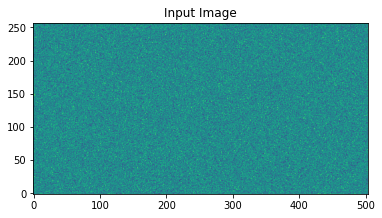

In [57]:
"""image to input in generative network"""
#input_img = content_img.clone()

# if you want to use a white noise instead uncomment the below line:
#input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

def in_img(n_freqs, nsamples):
    """initialize (runs) number of unique random noise input images"""  
    input_imgs = []
    #rand_tensor = torch.randn(1,n_freqs,1,nsamples)*1e-3
    lower,upper,mu,sigma = 1e-3,1,.5,1e-1
    dist = stats.truncnorm((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
    
    i = 0
    while i < runs:
         #[batch,channels,h,w]
        if whichChannel == "2d":
            samples = dist.rvs([1,1,n_freqs,nsamples])
            input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            #input_imgs.append(Variable(torch.rand(1,1,n_freqs,nsamples)*1e-3).type(dtype))
            #input_imgs.append(Variable(torch.randn(1,1,n_freqs,nsamples)*1e-3).type(dtype))
        if whichChannel == "freq":
            #samples = dist.rvs([1,n_freqs,1,nsamples])
            #input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            #input_imgs.append(Variable(torch.rand(1,n_freqs,1,nsamples)*1e-3).type(dtype))
            input_imgs.append(Variable(mu+torch.randn(1,n_freqs,1,nsamples)*1e-3).type(dtype))
        elif whichChannel == "time":
            samples = dist.rvs([1,nsamples,1,n_freqs])
            input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            #input_imgs.append(Variable(torch.rand(1,nsamples,1,n_freqs)*1e-3).type(dtype))
            #input_imgs.append(Variable(torch.randn(1,nsamples,1,n_freqs)*1e-3).type(dtype))
        i +=1
    return input_imgs

input_imgs = in_img(N_FREQ, int(N_SAMPLES*SYNTHETIC_LENGTH_FACTOR))

# add the original input image to the figure:
plt.figure()
_=imshow(input_imgs[0].data, N_FREQ, int(N_SAMPLES*SYNTHETIC_LENGTH_FACTOR), title='Input Image')

Gradient descent
~~~~~~~~~~~~~~~~

As Leon Gatys, the author of the algorithm, suggested
`here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__,
we will use L-BFGS algorithm to run our gradient descent. Unlike
training a network, we want to train the input image in order to
minimise the content/style losses. We would like to simply create a
PyTorch  L-BFGS optimizer, passing our image as the variable to optimize.
But ``optim.LBFGS`` takes as first argument a list of PyTorch
``Variable`` that require gradient. Our input image is a ``Variable``
but is not a leaf of the tree that requires computation of gradients. In
order to show that this variable requires a gradient, a possibility is
to construct a ``Parameter`` object from the input image. Then, we just
give a list containing this ``Parameter`` to the optimizer's
constructor:




In [58]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

**Last step**: the loop of gradient descent. At each step, we must feed
the network with the updated input in order to compute the new losses,
we must run the ``backward`` methods of each loss to dynamically compute
their gradients and perform the step of gradient descent. The optimizer
requires as argument a "closure": a function that reevaluates the model
and returns the loss.

In [59]:
def run_style_transfer(cnnlist, style_img, input_img, content_img=None, num_steps=num_steps,
                       style_weight=1, content_weight=0, reg_weight=0.01): 
    """Run the style transfer"""
    
    #MS - one model, loss accumulator, and optimizer per stream 
    modelMS=[None for j in range(numStreams)]
    style_lossesMS=[None for j in range(numStreams)] 
    content_lossesMS=[None for j in range(numStreams)]
    optimizerMS=[None for j in range(numStreams)]

    #MS one input_param for all streams, each operating on the same data. 
    input_param = nn.Parameter(input_img.data)
    
    
    prev = input_param.data
    
    # first create the separate cnn models and losses
    for j in range(numStreams) :
        print('Building the style transfer model..')
        modelMS[j], style_lossesMS[j], content_lossesMS[j] = get_style_model_and_losses(cnnlist[j],
            style_img, content_img, style_weight, content_weight)
        #input_paramMS[j], optimizerMS[j] = get_input_param_optimizer(input_img)
        
        #input_param is the same variable passed to each separate CNN
        #MS Changed learning rate to prevent instabilities with lr=1.
        optimizerMS[j] = optim.LBFGS([input_param], lr=learning_Rate)

        print("Input range:",torch.max(input_param.data),torch.min(input_param.data))   
        print(modelMS[j])
        print('Optimizing..')
        
    
    print(f'Created {j} MS models')
    # print(f' input_param[0] is input_param[1] ? ...... {input_paramMS[0] is input_paramMS[1]}')    # FALSE!    
    

    run = [0]
    
    if boundopt == True:
        bound = OptReg(1,0.005, reg_weight)
    
    while run[0] <= num_steps:

        run[0] += 1
        
        #MS create the closure, and then run the optimizer for each stream in sequence
        # (the update from each stream becomes the input for the next, I think!)
        for j in range(numStreams) :
        
            def closure():
                # correct the values of updated input image
                #if use01scale == True:
                    #input_param.data.clamp_(0, 1)

                optimizerMS[j].zero_grad()
                modelMS[j](input_param)
                style_score = 0
                content_score = 0

                if boundopt == True:
                    bound.zero_grad()
                    reg = bound(input_param)
                    if not torch.equal(reg.data,torch.cuda.FloatTensor([0])):
                        reg.backward()

                for sl in style_lossesMS[j]:
                    style_score += sl.backward() #call backward method to grab the loss

                #for cl in content_losses:
                #    content_score += cl.backward()

                if boundopt == True:
                    total_loss = style_score + reg  #+ content_score
                else:
                    total_loss = style_score

                #run[0] += 1

                if run[0] % 10 == 0:
                    #print("reg", reg)
                    #print(torch.max(input_param.data),torch.min(input_param.data))

                    print(f"run: {run}, model[{j}]")
                    print('Style Loss : {:4f}'.format(
                        #style_score.data[0]))
                        style_score.data))
                    if boundopt == True:
                        print('Bound Loss : {:4f}'.format(
                           #reg.data[0]))
                            reg.data))
                    print(torch.max(input_param.data),torch.min(input_param.data))
                    print('Total Loss : {:4f}'.format(
                        # total_loss.data[0]))
                        total_loss.data))

                return total_loss   #return value for closer()
            # The update to an image happens in here:
            optimizerMS[j].step(closure)  #optimizer.step will call closure with its closure vars;
                
          
        # END MS loop
        
        
        
    # a last correction...
    #if use01scale == True:
        #input_param.data.clamp_(0, 1)

    return input_param.data   # Can return any of the MS input_params - they all refer to the same object

<div style="background-color: #AAFFAA">
<h4> Finally, run the algorithm  </h4>
</div>  

Building the style transfer model..
Input range: tensor(0.5047, device='cuda:0') tensor(0.4956, device='cuda:0')
Sequential(
  (conv_1): Conv2d(257, 256, kernel_size=(1, 5), stride=(1, 1), bias=False)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (pool_2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(256, 128, kernel_size=(1, 5), stride=(1, 1), bias=False)
  (relu_2): ReLU()
  (style_loss_2): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
)
Optimizing..
Building the style transfer model..
Input range: tensor(0.5047, device='cuda:0') tensor(0.4956, device='cuda:0')
Sequential(
  (conv_1): Conv2d(257, 256, kernel_size=(1, 5), stride=(1, 1), bias=False)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (pool_2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
 

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


run: [10], model[0]
Style Loss : 4629.481445
tensor(0.5363, device='cuda:0') tensor(0.4399, device='cuda:0')
Total Loss : 4629.481445
run: [10], model[0]
Style Loss : 4621.602539
tensor(0.5366, device='cuda:0') tensor(0.4394, device='cuda:0')
Total Loss : 4621.602539
run: [10], model[0]
Style Loss : 4613.922852
tensor(0.5369, device='cuda:0') tensor(0.4389, device='cuda:0')
Total Loss : 4613.922852
run: [10], model[0]
Style Loss : 4606.363770
tensor(0.5372, device='cuda:0') tensor(0.4385, device='cuda:0')
Total Loss : 4606.363770
run: [10], model[0]
Style Loss : 4598.669922
tensor(0.5375, device='cuda:0') tensor(0.4380, device='cuda:0')
Total Loss : 4598.669922
run: [10], model[0]
Style Loss : 4591.241699
tensor(0.5378, device='cuda:0') tensor(0.4375, device='cuda:0')
Total Loss : 4591.241699
run: [10], model[0]
Style Loss : 4583.698242
tensor(0.5380, device='cuda:0') tensor(0.4371, device='cuda:0')
Total Loss : 4583.698242
run: [10], model[0]
Style Loss : 4576.141113
tensor(0.5383, de

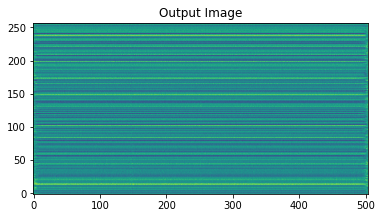

In [60]:
outputs = []
i = 0
while i < runs:
    
    output = run_style_transfer(cnnlist, style_img, input_imgs[i])

    plt.figure()
    out = imshow(output, N_FREQ, int(N_SAMPLES*SYNTHETIC_LENGTH_FACTOR),title='Output Image')
    outputs.append(out)
    i += 1

# sphinx_gallery_thumbnail_number = 4
plt.show()

Min/Max of outputs:  -1.3655451536178589,1.661866545677185


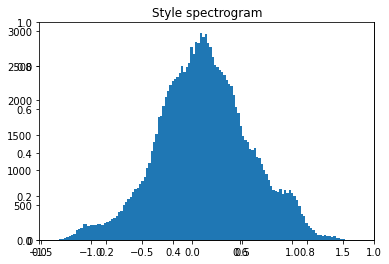

TIFResi: inv_log_spectrogram
   inv_log_spectrogram: Min/Max of outputs:  -0.7447584867477417,4.269136905670166


In [61]:
#SPECTOFFSET
SPECTOFFSET=0

##out_spec = inv_scale(out,shf)
for j in range(len(outputs)):
    print(f'Min/Max of outputs:  {np.amin(outputs[j])},{np.amax(outputs[j])}') # check values make sense
    fig = plt.figure()
    plt.title('Style spectrogram')
    ax = fig.add_subplot(111)
    n,b,_ = ax.hist(outputs[j].flatten(),bins='auto')
    plt.show()

if tifresi :
    #### Shift log spec to use max range before thresholding for tfresi inversion
    #outputs=[x+1-np.amax(x) for x in outputs]
    print('TIFResi: inv_log_spectrogram')
    if use01scale == True:
        foo = [img_invscale(x,a_min,a_max,0,1) for x in outputs]
        out_spec = [inv_log_spectrogram(x+SPECTOFFSET) for x in foo]
        for j in range(len(outputs)):
            print(f'   RESCALED: Min/Max of outputs:  {np.amin(foo[j])},{np.amax(foo[j])}') # check values make sense

    else:
        out_spec = [inv_log_spectrogram(x+SPECTOFFSET) for x in outputs] 
        #out_spec = [inv_log(x+SPECTOFFSET) for x in outputs]
        for j in range(len(outputs)):
            print(f'   inv_log_spectrogram: Min/Max of outputs:  {np.amin(out_spec[j])},{np.amax(out_spec[j])}') # check values make sense

else : 
    print('HUZ: inv_log')
    if use01scale == True:
        out_spec = [inv_log(img_invscale(x,a_min,a_max,0,1)) for x in outputs]
    else:
        out_spec = [inv_log(x) for x in outputs]

    for j in range(len(out_spec)):
        print(f'Min/Max of out_spec: {np.amin(out_spec[j])}, {np.amax(out_spec[j])}') # check values make sense
              
        

out_spec lene is 1
shape of value is (257, 504)
TIFResi invert mag to audio
Min/Max of spectrogram: 0.0, 4.269136905670166
Spectrogram values range over [-0.7447584867477417,4.269136905670166 ]


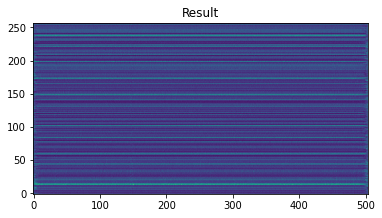

In [62]:
# Griffin & Lim algo for phase reconstruction (not used for tifresi)

print(f'out_spec lene is {len(out_spec)}')
for index,value in enumerate(out_spec):
    print(f'shape of value is {value.shape}')
    if tifresi :
        print(f'TIFResi invert mag to audio')
        S = value
        bar=S#-np.amin(S)+.0001
        #bar=bar/np.amax(bar)
        bar = np.clip(bar, 0,None)
        print(f'Min/Max of spectrogram: {np.amin(bar)}, {np.amax(bar)}') # check values make sense
        x = stft_system.invert_spectrogram(bar) 
    else :
        print(f'Huz invert mag to audio')
        p = 2 * np.pi * np.random.random_sample(value.shape) - np.pi #start with some phase
        #Griffin Lim
        for i in range(500):
            S = value * np.exp(1j*p) #use magnitude a given by spectrogram and some random phase
            x = librosa.istft(S,hop_length=K_HOP, win_length=N_FFT, center=False) #do the inverse transform
            p = np.angle(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT, center=False)) #use this new phase value

    try:
        os.makedirs("outputs/" + outname)
    except FileExistsError:
        # directory already exists
        pass

    OUTPUT_FILENAME="outputs/" + outname + '/' + outname + '_' + str(index) + '.wav'
    #librosa.output.write_wav("outputs/" + outname + '/' + outname + '_' + str(index) + '.wav', x, fs)
    sf.write(OUTPUT_FILENAME, x, fs)
    print(f'Spectrogram values range over [{np.amin(value)},{np.amax(value)} ]')
    plt.figure()
    plt.title('Result')
    plt.imshow(value,  origin='lower')
    plt.show()

plt.ioff()

In [63]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME, autoplay=True))

outputs/rftests/rftests_0.wav


In [64]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1024, eps=[0.4, 0.1, 0.01])

array([   472,   5941, 558239])

In [65]:
from scipy.stats import ortho_group

x = ortho_group.rvs(N_FILTERS)[:N_FILTERS//2]


In [66]:
np.dot(x[20], x[31])

1.0408340855860843e-16

In [67]:
np.dot(x[0], x[1])

-1.6046192152785466e-16

In [68]:

RFM.shape

AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
x.shape